In [1]:
from typing import Mapping
import numbers

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sbi.utils
import sbi.analysis
import sbi.inference
import torch

from brian2 import (get_device, get_local_namespace, Quantity, NeuronGroup,
                    Network, StateMonitor, umetre, second, ms, volt, mV, amp,
                    nA, siemens, uS, nS, farad, pF, ufarad, cm)
from brian2.input import TimedArray
from brian2.core.functions import Function
from brian2.equations.equations import Equations
from brian2.devices import set_device, reset_device, device
from brian2.devices.cpp_standalone.device import CPPStandaloneDevice
from brian2.units.fundamentalunits import DIMENSIONLESS, get_dimensions


from brian2modelfitting.simulator import (RuntimeSimulator,
                                          CPPStandaloneSimulator)

In [2]:
def setup_fit():
    simulators = {'CPPStandaloneDevice': CPPStandaloneSimulator(),
                  'RuntimeDevice': RuntimeSimulator()}
    if isinstance(get_device(), CPPStandaloneDevice):
        if device.has_been_run is True:
            build_options = dict(device.build_options)
            get_device().reinit()
            get_device().activate(**build_options)
    return simulators[get_device().__class__.__name__]

In [3]:
def get_full_namespace(additional_namespace, level=0):
    namespace = {key: value
                 for key, value in get_local_namespace(level=level + 1).items()
                 if isinstance(value, (Quantity, numbers.Number, Function))}
    namespace.update(additional_namespace)
    return namespace

In [4]:
def get_param_dic(params, param_names, n_samples):
    params = np.array(params)
    d = dict()
    for name, value in zip(param_names, params.T):
        d[name] = (np.ones((n_samples, )) * value)
    return d

In [5]:
def calc_prior(parameter_names, **params):
    for param in parameter_names:
        if param not in params:
            raise TypeError(f'"Bounds must be set for parameter {param}')
    prior_min = []
    prior_max = []
    for name in parameter_names:
        prior_min.append(min(params[name]).item())
        prior_max.append(max(params[name]).item())
    prior = sbi.utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min),
                                            high=torch.as_tensor(prior_max))
    return prior

In [6]:
class Inferencer(object):
    def __init__(self, dt, model, input, output, method=None, threshold=None,
                 reset=None, refractory=None, param_init=None):
        self.dt = dt
        
        if isinstance(model, str):
            self.model = Equations(model)
        else:
            raise TypeError('Equations must be appropriately formatted.')
        
        if not isinstance(input, Mapping):
            raise TypeError('`input` argument must be a dictionary mapping'
                            ' the name of the input variable and `input`.')
        if len(input) > 1:
            raise NotImplementedError('Only a single input is supported.')
        self.input_var = list(input.keys())[0]
        self.input = input[self.input_var]
        
        if not isinstance(output, Mapping):
            raise TypeError('`output` argument must be a dictionary mapping'
                            ' the name of the output variable and `output`')
        if len(output) > 1:
            raise NotImplementedError('Only a single output is supported')
        self.output_var = list(output.keys())[0]
        self.output = output[self.output_var]
        
        input_dim = get_dimensions(self.input)
        input_dim = '1' if input_dim is DIMENSIONLESS else repr(input_dim)
        input_eqs = f'{self.input_var} = input_var(t) : {input_dim}'
        self.model += input_eqs
        
        self.input_traces = TimedArray(self.input.transpose(), dt=self.dt)
        
        n_steps = self.input.size
        self.sim_time = self.dt * n_steps
        
        if not param_init:
            param_init = {}
        for param, val in param_init.items():
            if not (param in self.model.diff_eq_names or
                    param in self.model.parameter_names):
                raise ValueError(f'{param} is not a model variable or a'
                                 ' parameter in the model')
        self.param_init = param_init
        
        self.param_names = self.model.parameter_names
        self.method = method
        self.threshold = threshold
        self.reset = reset
        self.refractory = refractory
    
    def setup_simulator(self, n_samples, output_var, param_init, level=1):
        simulator = setup_fit()
        
        namespace = get_full_namespace({'input_var': self.input_traces},
                                       level=level+1)
        namespace[f'output_var'] = TimedArray(self.output.transpose(), dt=self.dt)
        
        kwargs = {}
        if self.method is not None:
            kwargs['method'] = self.method
        model = self.model + Equations('iteration : integer (constant, shared)')
        neurons = NeuronGroup(N=n_samples,
                              model=model,
                              threshold=self.threshold,
                              reset=self.reset,
                              refractory=self.refractory,
                              dt=self.dt,
                              namespace=namespace,
                              name='neurons',
                              **kwargs)
        network = Network(neurons)
        network.add(StateMonitor(source=neurons, variables=output_var,
                                 record=True, dt=self.dt, name='statemonitor'))
        simulator.initialize(network, param_init)
        return simulator

    def generate(self, n_samples, level=0, **params):
        try:
            n_samples = int(n_samples)
        except ValueError as e:
            print(e)
        for param in params:
            if param not in self.param_names:
                raise ValueError(f'Parameter {param} must be defined as a'
                                 ' model\'s parameter')
        self.prior = calc_prior(self.param_names, **params)
        self.theta = self.prior.sample((n_samples, ))
        theta = np.atleast_2d(self.theta.numpy())
        
        self.simulator = self.setup_simulator(n_samples=n_samples,
                                              output_var=self.output_var,
                                              param_init=self.param_init,
                                              level=1)
        d_param = get_param_dic(theta, self.param_names, n_samples)
        self.simulator.run(self.sim_time, d_param, self.param_names, 0)
        
    def _create_summ_stats(self, obs, obs_dim):
        obs_mean = obs.mean(axis=0)
        obs_std = obs.std(axis=0)
        obs_ptp = obs.ptp(axis=0)
        obs_mean = obs_mean / Quantity(np.ones_like(obs_mean), obs_dim)
        obs_std = obs_std / Quantity(np.ones_like(obs_std), obs_dim)
        obs_ptp = obs_ptp / Quantity(np.ones_like(obs_ptp), obs_dim)
        return np.hstack((np.asarray(obs_mean).reshape(-1, 1),
                          np.asarray(obs_std).reshape(-1, 1),
                          np.asarray(obs_ptp).reshape(-1, 1)))
        
    def train(self):
        obs = self.simulator.statemonitor.recorded_variables[self.output_var].get_value_with_unit()
        obs_dim = get_dimensions(self.simulator.statemonitor.recorded_variables[self.output_var])
        x = torch.tensor(self._create_summ_stats(obs, obs_dim), dtype=torch.float32)
        density_esimator = sbi.utils.posterior_nn(model='maf')
        self.inference = sbi.inference.SNPE(self.prior, density_esimator)
        self.inference.append_simulations(self.theta, x).train()
        self.posterior = self.inference.build_posterior()
    
    def sample(self, size, viz=False, **kwargs):
        obs_dim = get_dimensions(self.output)
        x_o = torch.tensor(self._create_summ_stats(self.output.ravel(), obs_dim), dtype=torch.float32)
        samples = self.posterior.sample((size, ), x_o)
        if viz == True:
            sbi.analysis.pairplot(samples, **kwargs)
            plt.tight_layout()
            plt.show()
        return samples

Neural network successfully converged after 160 epochs.


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

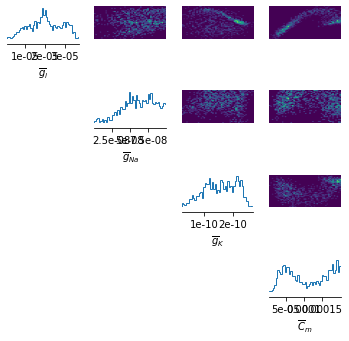

In [7]:
df_inp_traces = pd.read_csv('data/input_traces_hh.csv')
df_out_traces = pd.read_csv('data/output_traces_hh.csv')

inp_traces = df_inp_traces.to_numpy()
inp_traces = inp_traces[0, 1:]

out_traces = df_out_traces.to_numpy()
out_traces = out_traces[0, 1:]

area = 20000*umetre**2
El = -65*mV
EK = -90*mV
ENa = 50*mV
VT = -63*mV
dt = 0.01*ms
eqs='''
    dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt
    dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
        (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
        (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
    dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
        (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
    dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
    g_na : siemens (constant)
    g_kd : siemens (constant)
    gl   : siemens (constant)
    Cm   : farad (constant)
'''
labels_params = [r'$\overline{g}_{l}$', r'$\overline{g}_{Na}$',
                 r'$\overline{g}_{K}$', r'$\overline{C}_{m}$']

inferencer = Inferencer(dt=dt, model=eqs,
                        input={'I': inp_traces*amp},
                        output={'v': out_traces*mV},
                        method='exponential_euler',
                        threshold='m>0.5',
                        refractory='m>0.5',
                        param_init={'v': 'VT'})

inferencer.generate(n_samples=1000,
                    gl = [1e-09 *siemens, 1e-07 *siemens],
                    g_na = [2e-06*siemens, 2e-04*siemens],
                    g_kd = [6e-07*siemens, 6e-05*siemens],
                    Cm=[0.1*ufarad*cm**-2 * area, 2*ufarad*cm**-2 * area])
inferencer.train()
samples = inferencer.sample(1000, viz=True,
                            labels=labels_params, figsize=(5, 5))